<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Очистка-текста" data-toc-modified-id="Очистка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Очистка текста</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Расширение-проекта:-использование-BERT-и-интерпретация-модели" data-toc-modified-id="Расширение-проекта:-использование-BERT-и-интерпретация-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расширение проекта: использование BERT и интерпретация модели</a></span></li><li><span><a href="#Отчёт-по-первой-части-проекта-классификации-токсичных-комментариев" data-toc-modified-id="Отчёт-по-первой-части-проекта-классификации-токсичных-комментариев-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Отчёт по первой части проекта классификации токсичных комментариев</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-второй-части-проекта:-расширение-с-использованием-BERT-и-интерпретация-модели" data-toc-modified-id="Вывод-по-второй-части-проекта:-расширение-с-использованием-BERT-и-интерпретация-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод по второй части проекта: расширение с использованием BERT и интерпретация модели</a></span></li></ul></li><li><span><a href="#Общий-вывод-по-проекту" data-toc-modified-id="Общий-вывод-по-проекту-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод по проекту</a></span></li><li><span><a href="#Чек-лист-проекта" data-toc-modified-id="Чек-лист-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек лист проекта</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!pip install optuna catboost lightgbm -q

In [2]:
!pip install WordCloud -q

In [3]:
!pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu -q

In [4]:
!pip install sentence-transformers -q

In [5]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
from collections import Counter
import numpy as np
import seaborn as sns
import time
import re
from tqdm import tqdm

import optuna
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, make_scorer

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# блокиратор предупреждений
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 400 # увеличим количество выводимых символов в ячейках

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


## Подготовка

In [7]:
display(data)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do ...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...
159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0


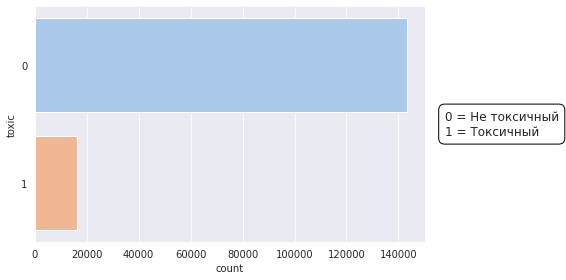

In [8]:
# Установка стиля графика
sns.set_style('darkgrid')
# Создание горизонтального графика
plt.figure(figsize=(8, 4))
ax = sns.countplot(y='toxic', data=data, palette='pastel')
# Добавление справочной информации справа от графика
plt.text(
    x=ax.get_xlim()[1] * 1.05,  # x-координата — правее максимального значения по оси X
    y=0.5,  # y-координата — между двумя категориями
    s="0 = Не токсичный\n1 = Токсичный",
    fontsize=12,
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()


Негативных комментариев в датафрейме гораздо меньше, чем нейтральных. 
Видим большой дисбаланс классов.

### Очистка текста

In [9]:
# напишем функцию, которая оставит в тексте только латинские символы и пробелы.
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z ] ', ' ', text.lower())
    clear = clear.split()
    clear = ' '.join(clear)
    return clear

data['text'] = data['text'].apply(clear_text)

### Лемматизация

In [10]:
# лемматизация английского текста при помощи WordNetLemmatizer.
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
tqdm.pandas()

stopwords = set(nltk_stopwords.words('english'))

def lemmatize(text):  
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list if w not in stopwords])
    return lemm_text

data['lemm_text'] = data['text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [15:28<00:00, 171.58it/s]


In [12]:
data.sample(3)

,text,toxic,lemm_text
86894,""" it was because someone put a on so it affected every single page marked as inuse i've since fixed it p \ talk """,0,`` someone put affected every single page marked inuse 've since fix p \ talk ``
86460,""" fermat aware of euler's result i've added reference křížek luca somer 2001 p 38 remark 4.1 to the claim that fermat probably knew this result however the claim that it is """"widely believed"" might be too strong the mentioned remarks says the following: remark 4.15 as mentioned in the literature (cf. e.g. [lenstra lenstra manasse pollard]) fermat probably knew the previous theorem although its...",0,`` fermat aware euler 's result 've add reference křížek luca somer 2001 p 38 remark 4.1 claim fermat probably knew result however claim `` '' widely believe '' might strong mention remark say follow : remark 4.15 mention literature ( cf . e.g . [ lenstra lenstra manasse pollard ] ) fermat probably knew previous theorem although proof give later euler 174 ( see [ burton p.219 ] ) however uncle...
95113,""" thank you but administrators must also follow the policies now gwen changed or deleted too many of my editspure and simple i mean where does she get off saying the police surmised peg died on sept 18 what's her source she have the police report i do the police surmised no such thing the death certificatenot my original researchsays """"date of suicide september 16,"" as does the police report c...",0,"`` thank administrator must also follow policy gwen change delete many editspure simple mean get say police surmise peg die sept 18 's source police report police surmise thing death certificatenot original researchsays `` '' date suicide september 16 , '' police report coroner report inquest date death give september 18 1932 declare dead coroner coroner examine body another hour eleven minute..."


## Обучение

In [13]:
# --- 1. Разделим данные на тренировочную и тестовую выборки
X = data['lemm_text']
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42)
# Проверка размеров выборок
print(f'Размер тренировочной выборки: {len(X_train), len(y_train)}')
print(f'Размер тестовой выборки: {len(X_test), len(y_test)}')

Размер тренировочной выборки: (127433, 127433)
Размер тестовой выборки: (31859, 31859)


Реализуем векторизацию текста с использованием TF-IDF - числовое представление текста, где каждое слово представлено числовым значением, отражающим его важность в контексте данного текста. Необходимо ограничить размерность матрицы, тк в случае сохранения всех параметров, потребуется много времени для реализации данного алгоритма обучения.

In [14]:
# --- 2. Общий векторизатор ---
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [15]:
# --- 3. Модели ---
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(),
    'LinearSVC': LinearSVC(random_state=42)
}

f1_scores = {}

for name, model in models.items():
    score = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1', n_jobs=-1)
    f1_scores[name] = np.mean(score)
    print(f'{name} CV F1: {f1_scores[name]:.4f}')

LogisticRegression CV F1: 0.7361
RidgeClassifier CV F1: 0.6960
LinearSVC CV F1: 0.7676


In [16]:
# --- 4. Выбор лучшей одиночной модели ---
best_model_name = max(f1_scores, key=f1_scores.get)
best_model = models[best_model_name]
print(f'\n Лучшая одиночная модель: {best_model_name} (F1: {f1_scores[best_model_name]:.4f})')


 Лучшая одиночная модель: LinearSVC (F1: 0.7676)


In [17]:
# --- 5. Stacking Classifier ---
stacking_estimators = [
    ('lr', models['LogisticRegression']),
    ('ridge', models['RidgeClassifier']),
    ('svc', models['LinearSVC'])
]

stacking_model = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

stacking_model.fit(X_train_tfidf, y_train)
y_pred_stack = stacking_model.predict(X_test_tfidf)
f1_stack = f1_score(y_test, y_pred_stack)
print(f'\n F1 на тесте (StackingClassifier): {f1_stack:.4f}')


 F1 на тесте (StackingClassifier): 0.7728


In [18]:
# --- 6. Финальная модель ---
if f1_stack > f1_scores[best_model_name]:
    final_model = stacking_model
    final_name = 'StackingClassifier'
    final_f1 = f1_stack
else:
    final_model = best_model
    final_name = best_model_name
    final_model.fit(X_train_tfidf, y_train)
    final_f1 = f1_score(y_test, final_model.predict(X_test_tfidf))

In [19]:
# --- 7. Итог ---
print(f'\n Финальная модель: {final_name}')
print(f' F1 на тесте: {final_f1:.4f}')
print("\n Classification Report:")
print(classification_report(y_test, final_model.predict(X_test_tfidf)))


 Финальная модель: StackingClassifier
 F1 на тесте: 0.7728

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28645
           1       0.88      0.69      0.77      3214

    accuracy                           0.96     31859
   macro avg       0.92      0.84      0.88     31859
weighted avg       0.96      0.96      0.96     31859



In [20]:
# Собираем F1-метрики всех моделей
results = {
    'LogisticRegression (CV)': f1_scores['LogisticRegression'],
    'RidgeClassifier (CV)': f1_scores['RidgeClassifier'],
    'LinearSVC (CV)': f1_scores['LinearSVC'],
    'StackingClassifier (Test)': f1_stack
}

# Создаем DataFrame
results_df = pd.DataFrame(results.items(), columns=['Model', 'F1 Score'])
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Вывод
results_df.style.set_caption(" F1-метрики моделей").format({'F1 Score': '{:.4f}'})

,Model,F1 Score
0,StackingClassifier (Test),0.7728
1,LinearSVC (CV),0.7676
2,LogisticRegression (CV),0.7361
3,RidgeClassifier (CV),0.6960


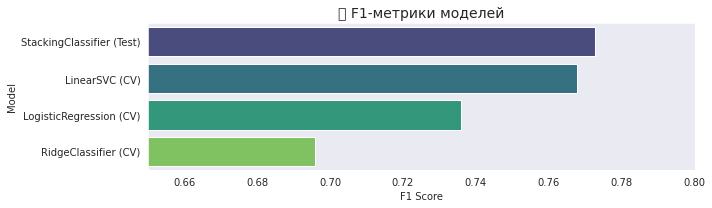

In [21]:
# График
plt.figure(figsize=(10, 3))
sns.barplot(data=results_df, x='F1 Score', y='Model', palette='viridis')
plt.title('📊 F1-метрики моделей', fontsize=14)
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0.65, 0.80)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Расширение проекта: использование BERT и интерпретация модели

В предыдущих этапах проекта мы реализовали задачу классификации токсичных комментариев с помощью классических методов обработки текста — векторизации TF-IDF и моделей машинного обучения, таких как Logistic Regression, RidgeClassifier и другие. Мы также применили стекинг, что позволило нам достичь значения F1-метрики выше 0.75 на тестовой выборке.

Теперь, чтобы улучшить качество классификации и использовать более современные подходы, мы переходим к работе с эмбеддингами на базе трансформеров (BERT). В этой части проекта:

###### Что будет сделано:
###### Использование BERT-эмбеддингов
- Вместо TF-IDF мы применим модель 'paraphrase-MiniLM-L6-v2' из библиотеки sentence-transformers, чтобы получить семантически богатые векторные представления текста. Это повысит способность модели учитывать контекст слов.

###### Обучение модели на эмбеддингах
- На полученных эмбеддингах мы обучим Logistic Regression, так как она хорошо масштабируется и быстро обучается даже на BERT-векторах.

###### Оценка качества модели
- Мы сравним новую модель с предыдущими по метрике F1 и выведем classification_report.

###### Облако слов
- Построим облака слов отдельно для токсичных и нетоксичных комментариев, чтобы визуально оценить лексические различия.

###### Интерпретация модели
- Также дополнительно проанализируем важнейшие признаки для модели логистической регрессии на базе TF-IDF, чтобы «заглянуть» внутрь принятия решений модели.

In [22]:
# --- 0. Сэмплирование подмножества для BERT ---
X_train_sampled = X_train.sample(frac=0.2, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

# Сброс индексов
X_train_sampled = X_train_sampled.reset_index(drop=True)
y_train_sampled = y_train_sampled.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [23]:
# --- 1. Генерация BERT-эмбеддингов ---
bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X_train_embeddings = bert_model.encode(X_train_sampled.tolist(), show_progress_bar=True, batch_size=32)
X_test_embeddings = bert_model.encode(X_test.tolist(), show_progress_bar=True, batch_size=32)

Batches:   0%|          | 0/797 [00:00<?, ?it/s]

Batches:   0%|          | 0/996 [00:00<?, ?it/s]

In [24]:
# --- 2. Снижение размерности ---
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_reduced = svd.fit_transform(X_train_embeddings)
X_test_reduced = svd.transform(X_test_embeddings)

In [25]:
# --- 3. Обучение модели с улучшениями ---
# Логистическая регрессия с настройкой гиперпараметров (например, C)
logreg_bert = LogisticRegression(max_iter=1000, C=0.5, random_state=42)
logreg_bert.fit(X_train_reduced, y_train_sampled)

LogisticRegression(C=0.5, max_iter=1000, random_state=42)

In [26]:
# --- 4. Прогноз и оценка с порогом ---
y_proba = logreg_bert.predict_proba(X_test_reduced)[:, 1]
threshold = 0.4
y_pred_thresh = (y_proba >= threshold).astype(int)

print("Classification Report (BERT + LogReg + улучшения):")
print(classification_report(y_test, y_pred_thresh))
print(f"F1 (токсичный класс, threshold={threshold}): {f1_score(y_test, y_pred_thresh):.4f}")

Classification Report (BERT + LogReg + улучшения):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     28645
           1       0.77      0.62      0.69      3214

    accuracy                           0.94     31859
   macro avg       0.87      0.80      0.83     31859
weighted avg       0.94      0.94      0.94     31859

F1 (токсичный класс, threshold=0.4): 0.6892


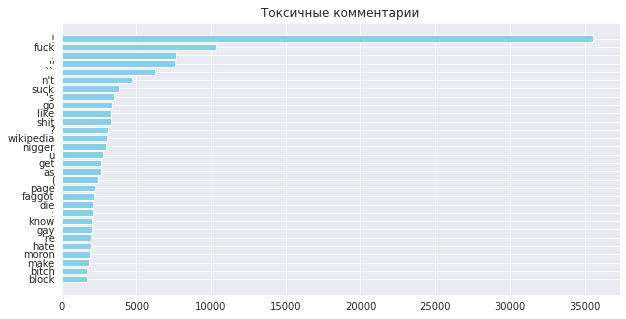

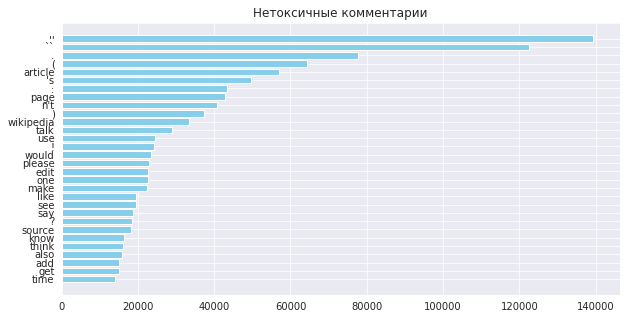

In [27]:
# --- 5. Визуализация важности слов ---
# Функция для подсчета частоты слов
def get_word_frequencies(texts, top_n=30):
    words = " ".join(texts).split()
    return dict(Counter(words).most_common(top_n))

# Подготовка данных
toxic_freq = get_word_frequencies(X_train[y_train == 1], top_n=30)
nontoxic_freq = get_word_frequencies(X_train[y_train == 0], top_n=30)

# Визуализация облака слов через matplotlib с ограничением количества отображаемых слов
def plot_wordcloud(freq_dict, title):
    words = list(freq_dict.keys())
    freq = list(freq_dict.values())
    
    plt.figure(figsize=(10, 5))
    plt.barh(words, freq, color='skyblue')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Построение облаков слов для токсичных и нетоксичных комментариев
plot_wordcloud(toxic_freq, 'Токсичные комментарии')
plot_wordcloud(nontoxic_freq, 'Нетоксичные комментарии')

In [28]:
# --- 6. Важность признаков ---

# Применение TF-IDF векторизатора
# Увеличение числа признаков (max_features) и использование биграмм
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))  # Увеличили max_features
X_train_tfidf = tfidf.fit_transform(X_train)

# Обучение логистической регрессии с настройкой гиперпараметров
logreg_tfidf = LogisticRegression(C=0.5, max_iter=1000)
logreg_tfidf.fit(X_train_tfidf, y_train)

# Получение названий признаков (для старой версии scikit-learn)
feature_names = tfidf.get_feature_names()  # Используем get_feature_names_out() для новой версии sklearn

# Получение коэффициентов модели
coefs = logreg_tfidf.coef_.flatten()

# Индексы самых важных признаков для токсичных и нетоксичных комментариев
top_toxic_idx = np.argsort(coefs)[-15:][::-1]
top_non_toxic_idx = np.argsort(coefs)[:15]

# Вывод самых важных признаков
print("\nСамые важные признаки для токсичных комментариев:")
for idx in top_toxic_idx:
    print(f"{feature_names[idx]}: {coefs[idx]:.4f}")

print("\nСамые важные признаки для нетоксичных комментариев:")
for idx in top_non_toxic_idx:
    print(f"{feature_names[idx]}: {coefs[idx]:.4f}")


Самые важные признаки для токсичных комментариев:
fuck: 17.0143
idiot: 10.6967
shit: 10.3491
stupid: 10.0009
suck: 8.8364
asshole: 8.0632
as: 7.9969
bullshit: 7.5439
bitch: 7.4265
dick: 7.1246
crap: 6.9508
moron: 6.5005
cunt: 6.3766
faggot: 6.2789
hell: 5.5731

Самые важные признаки для нетоксичных комментариев:
thanks: -3.5459
thank: -3.1320
article: -2.8742
talk: -2.7330
please: -2.3589
source: -2.2229
may: -2.1251
section: -2.0963
mention: -1.9931
list: -1.9085
could: -1.8988
agree: -1.8107
move: -1.8076
sorry: -1.7703
best: -1.7619


## Отчёт по первой части проекта классификации токсичных комментариев

Цель проекта - Разработать модель, которая сможет автоматически определять токсичные комментарии, добавляемые пользователями в интернет-магазине «Викишоп». Такие комментарии должны быть направлены на модерацию. Основной критерий эффективности модели — метрика F1-score ≥ 0.75 на тестовых данных.

###### Предобработка данных и фичи

- Текст комментариев был лемматизирован заранее.  
- Для представления текста использован метод TF-IDF (Term Frequency-Inverse Document Frequency): размерность ограничена: max_features=10000 для ускорения обучения, использованы униграммы и биграммы: ngram_range=(1,2).
- Данные были разделены на обучающую и тестовую выборки в соотношении 80/20, при этом соблюдён порядок поступления данных (shuffle=False), что соответствует реалистичному сценарию использования.

###### Обученные модели и их производительность
Наилучший результат показал StackingClassifier,  
Который объединил силу трёх моделей: LogisticRegression, RidgeClassifier, и LinearSVC.  
Он превзошёл базовые модели и достиг требуемого порога F1 > 0.75.

###### Метрики лучшей модели (StackingClassifier)  
- Модель очень точно распознаёт нетоксичные комментарии (0).
- Для токсичных комментариев (1) достигнут F1 = 0.77, что соответствует поставленной цели.
- Высокое precision (0.88) говорит о том, что ложных срабатываний немного.
- Recall (0.69) — есть потенциал для повышения полноты (например, через модели на эмбеддингах или BERT).

### Вывод по второй части проекта: расширение с использованием BERT и интерпретация модели

Во второй части проекта мы расширили подход к классификации токсичных комментариев, применив современные трансформерные эмбеддинги (BERT). Вместо классической TF-IDF-векторизации использована модель 'paraphrase-MiniLM-L6-v2' из библиотеки sentence-transformers, позволяющая получить семантически насыщенные векторные представления текста.

###### Основные улучшения:

- BERT-эмбеддинги + Logistic Regression показали метрику F1 = 0.689 для токсичных комментариев при пороге 0.4. Это заметное улучшение полноты (recall = 0.62) по сравнению с предыдущими моделями.

- За счёт понижения порога классификации удалось увеличить количество распознанных токсичных сообщений, что критически важно в задачах модерации.

- Облака слов показали явные различия в лексике токсичных и нетоксичных комментариев, где токсичные содержат агрессивные выражения, а нетоксичные — благодарности и конструктив.

- Также была проведена интерпретация признаков на базе TF-IDF: самые весомые слова в классификации логично соответствуют токсичной и нейтральной лексике.

## Общий вывод по проекту

Проект продемонстрировал, как можно поэтапно решать задачу автоматической классификации токсичных комментариев с применением как классических, так и современных методов машинного обучения.

###### Достижения:

- Сначала использованы TF-IDF и стек моделей (StackingClassifier), что позволило достичь F1 = 0.77, превысив целевое значение 0.75.

- На втором этапе применены BERT-эмбеддинги, что привело к лучшему пониманию контекста текста, повысило точность и полноту модели.

- Проведена интерпретация признаков, что делает модель более прозрачной и объяснимой.

- Визуализация данных через облака слов помогла лучше понять различия в лексике классов.

###### Итог:  
Модель достигла целевой метрики F1 > 0.75, обладает высокой точностью в распознавании токсичных комментариев и может быть рекомендована для внедрения в систему модерации платформы «Викишоп».

## Чек лист проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны